# Reconstruction of Simulated PET Phantom with MLEM (function in ODL)

iter = 0


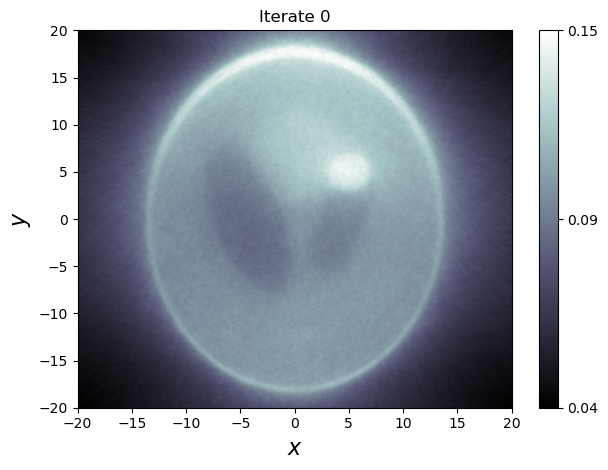

<Figure size 640x480 with 0 Axes>

iter = 1


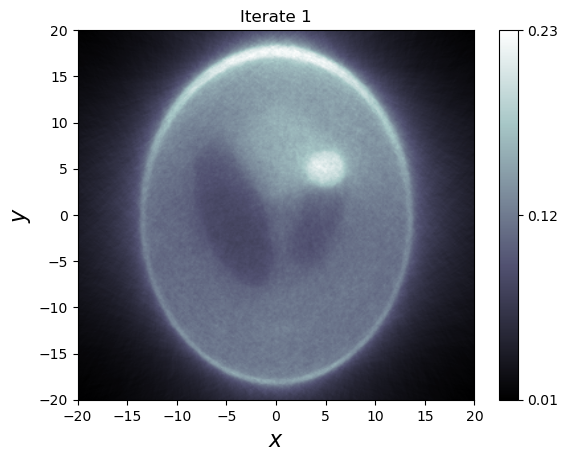

<Figure size 640x480 with 0 Axes>

iter = 2


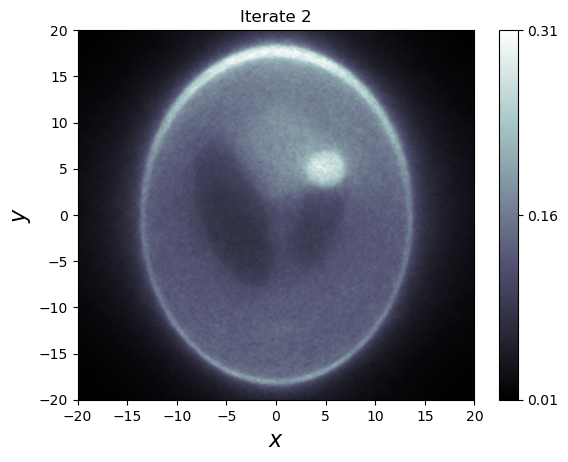

<Figure size 640x480 with 0 Axes>

iter = 3


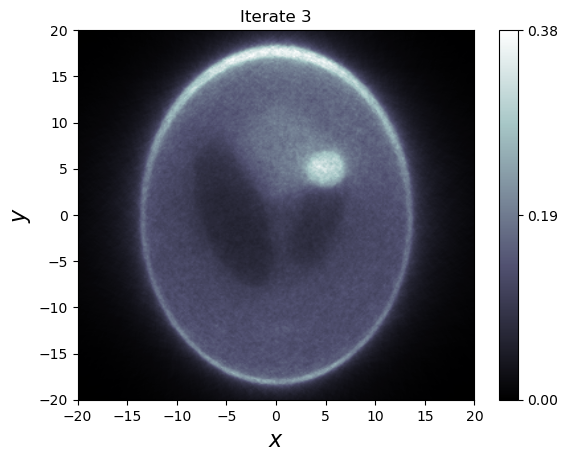

<Figure size 640x480 with 0 Axes>

iter = 4


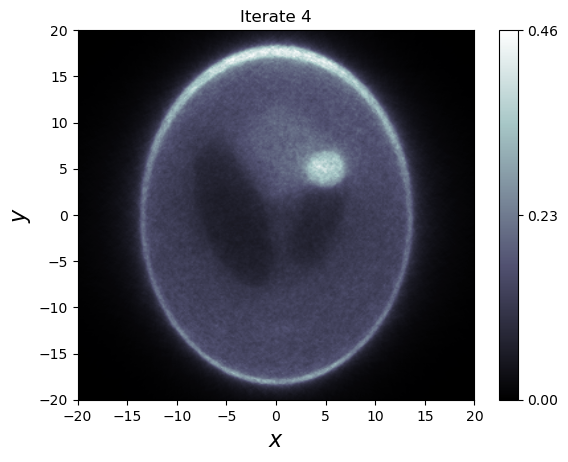

<Figure size 640x480 with 0 Axes>

iter = 5


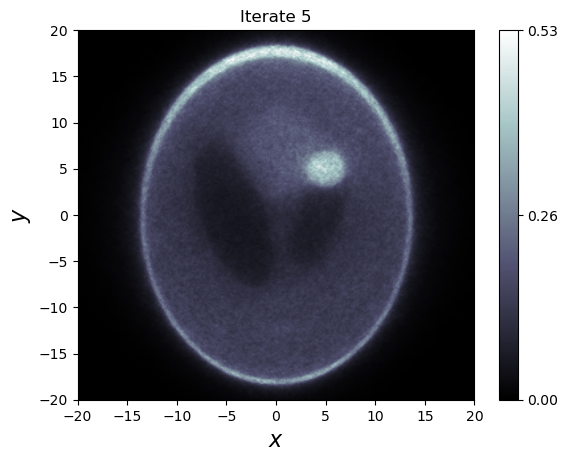

<Figure size 640x480 with 0 Axes>

iter = 6


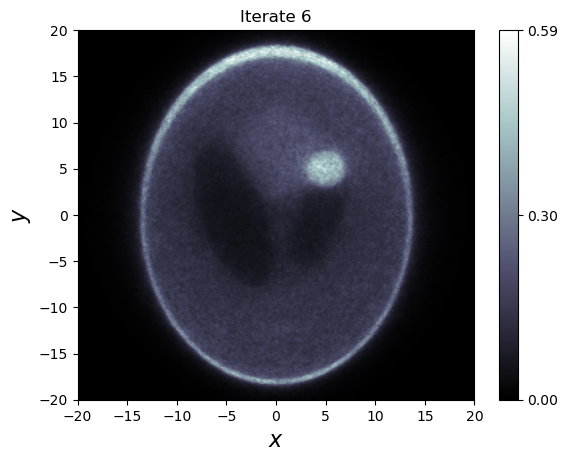

<Figure size 640x480 with 0 Axes>

iter = 7


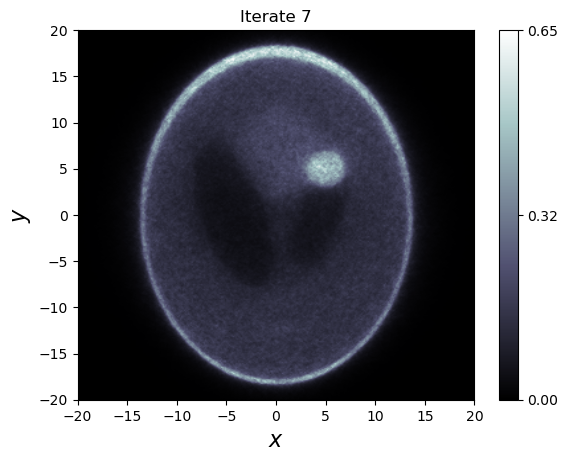

<Figure size 640x480 with 0 Axes>

iter = 8


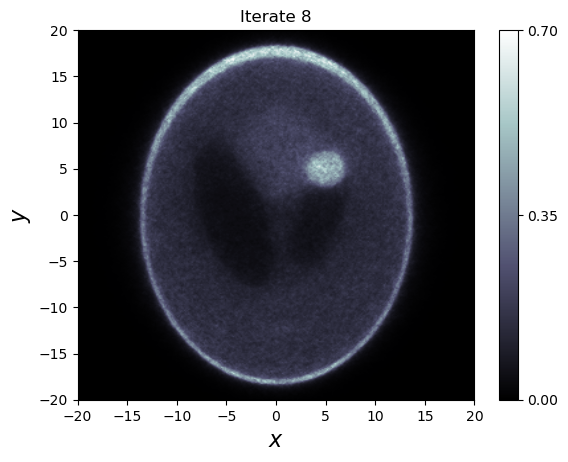

<Figure size 640x480 with 0 Axes>

iter = 9


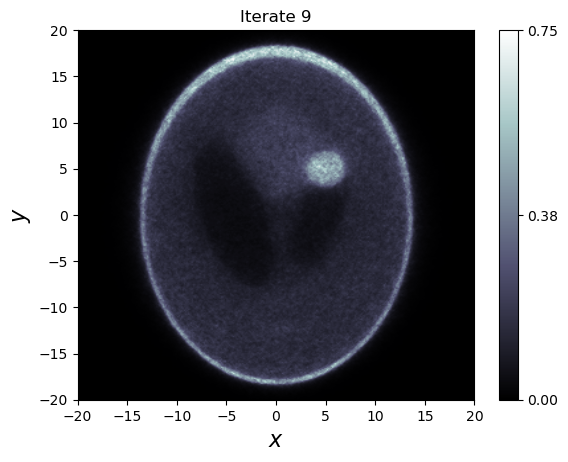

<Figure size 640x480 with 0 Axes>

iter = 10


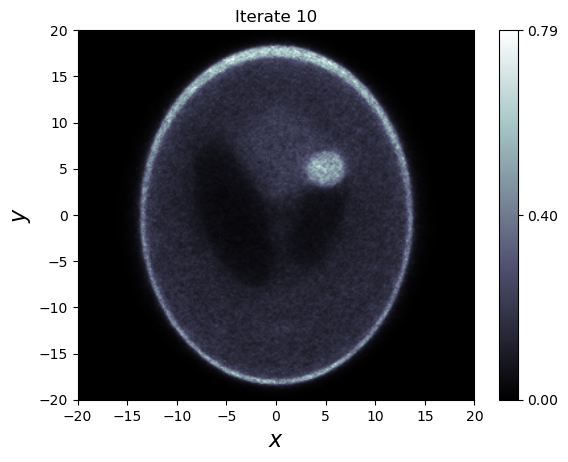

<Figure size 640x480 with 0 Axes>

iter = 11


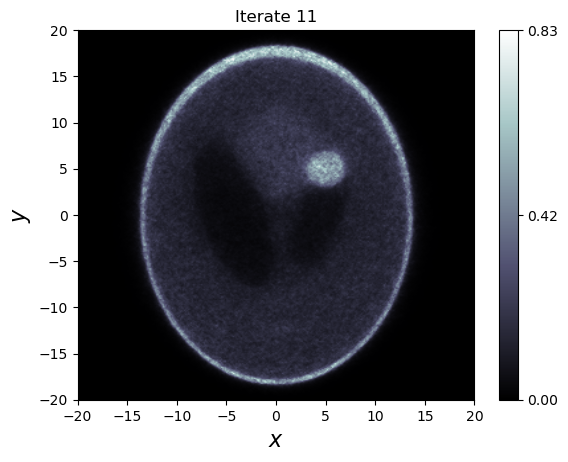

<Figure size 640x480 with 0 Axes>

iter = 12


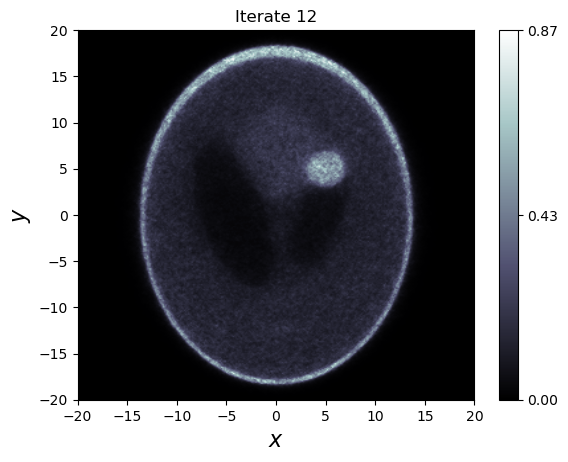

<Figure size 640x480 with 0 Axes>

iter = 13


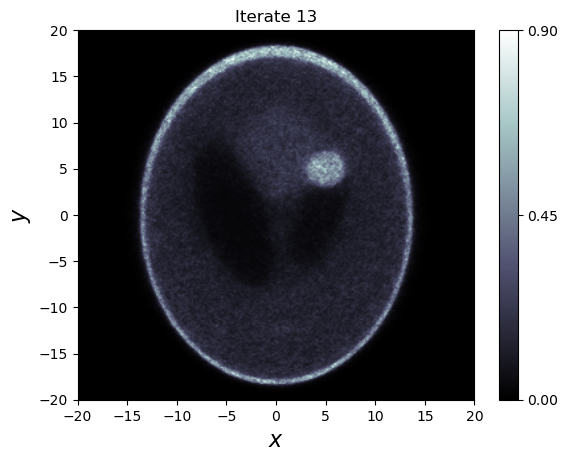

<Figure size 640x480 with 0 Axes>

iter = 14


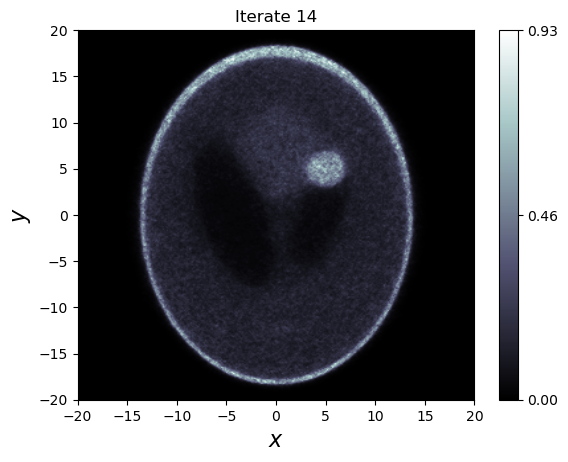

<Figure size 640x480 with 0 Axes>

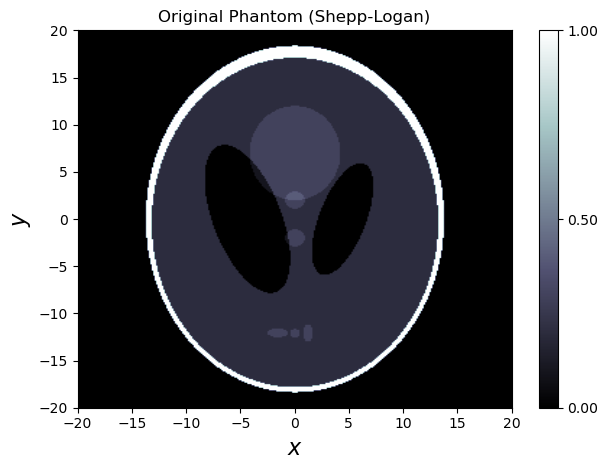

<Figure size 640x480 with 0 Axes>

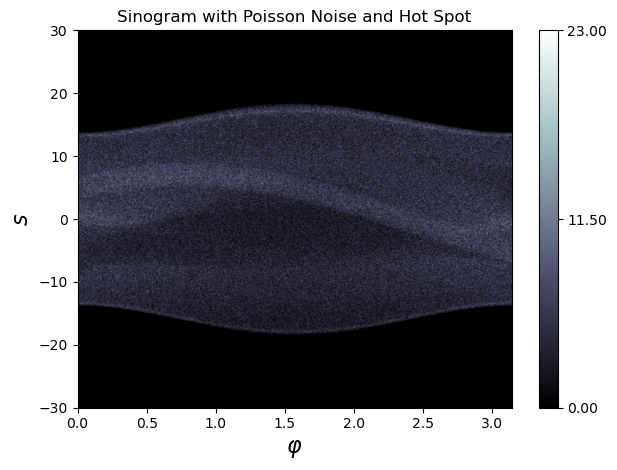

<Figure size 640x480 with 0 Axes>

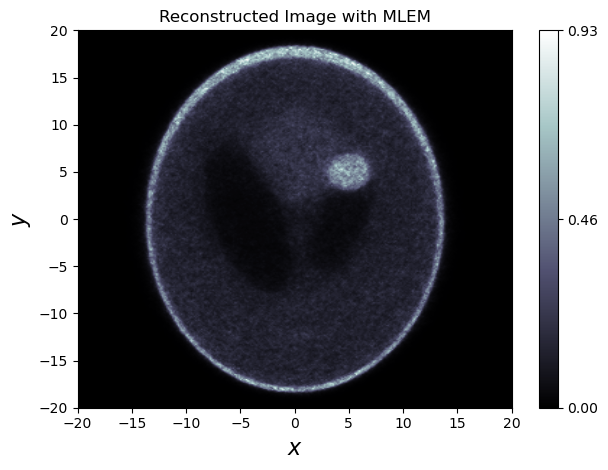

<Figure size 640x480 with 0 Axes>

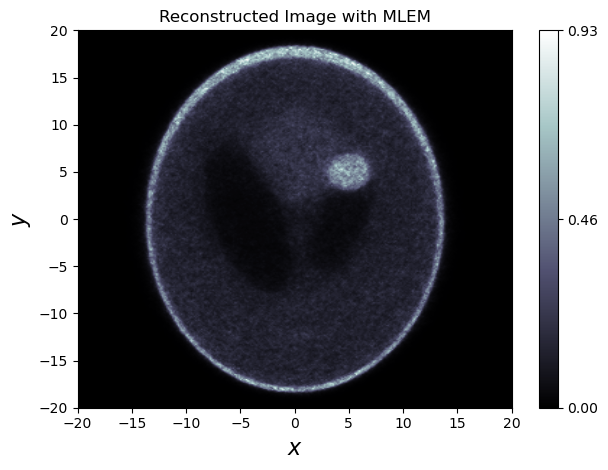

In [ ]:
import odl
import numpy as np
import matplotlib.pyplot as plt


# Define the reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[300, 300], dtype='float32'
)

# Define the angle partition 
angle_partition = odl.uniform_partition(0, np.pi, 1000)

# Define the detector partition
detector_partition = odl.uniform_partition(-30, 30, 500)

# Define a parallel beam geometry 
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Create the foward operator 
ray_trafo = odl.tomo.RayTransform(reco_space,geometry)

# Define the SHepp-Logan phantom  
shepp_logan = odl.phantom.shepp_logan(reco_space,modified = True)
og_data = ray_trafo(shepp_logan.copy())

# Convert the PET data to a NumPy array for manipulation
phantom_array = shepp_logan.asarray().copy()


# --- Create PET Phantom --- # 
# Simulate high-uptake regions by modifying intensity values
x, y = np.meshgrid(
    np.linspace(-20, 20, 300), np.linspace(-20, 20, 300)
)
hot_spot = ((x - 5)**2 + (y - 5)**2) < 2**2  # Circle at (5, 5) with radius 5
phantom_array[hot_spot] = phantom_array.max() * 0.8  # 0.8 the max intensity
phantom_array *= 0.7 # Scaling the overall intensity of the phantom

# Convert back to an ODL element
modified_phantom = reco_space.element(phantom_array)

# Convert to data space 
pet_data = ray_trafo(modified_phantom)
pet_data = odl.phantom.poisson_noise(pet_data)* 1.0


# --- Set up iterative MLEM solver for PET --- #
# Callback to print iteration and show results
callback = (odl.solvers.CallbackPrintIteration(step=1) &
            odl.solvers.CallbackShow(step=1))

# Number of iterations for MLEM
maxiter = 15

# Choose a starting point (initial guess)
reco_image = ray_trafo.domain.one()

# --- Run MLEM for PET reconstruction --- #
odl.solvers.iterative.statistical.mlem(ray_trafo, reco_image, pet_data, maxiter, callback=callback, noise='poisson')

# --- Display Results --- #
shepp_logan.show(title='Original Phantom (Shepp-Logan)')
pet_data.show(title='Sinogram with Poisson Noise and Hot Spot')
reco_image.show(title='Reconstructed Image with MLEM')
plt.show()
